# Hierarchical Bayesian Modeling of CD8+ T-cell Exhaustion Dynamics in Cancer Using scRNA-seq Data and Markov Chain Monte Carlo

# Part 4: Treatment Response Prediction Using Cell Exhaustion Scores

## Getting Started

#### Importing Libraries

In [1]:
import scanpy as sc
import numpy as np
import arviz as az
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

## Dataset

#### scRNAseq AnnData

In [2]:
# loading data
file_path = './dataset/cd8_adata.h5ad'
cd8_adata = sc.read_h5ad(file_path)

In [3]:
# Define gene lists
progenitor_ex_genes = ["TCF7", "CXCR5", "SLAMF6", "IL7R", "LEF1", "SELL", "STAT4", "FOXP1"]
terminal_ex_genes = ["PDCD1", "TOX", "HAVCR2", "CD38", "LAG3", "ENTPD1", "BATF", "LGALS9"]
selected_genes = progenitor_ex_genes + terminal_ex_genes

In [4]:
# Filter for pre-treatment patients
pre_patients = cd8_adata[
    cd8_adata.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.contains("Pre")
]

# Extract patient IDs
pre_patients.obs['patient_id'] = pre_patients.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.split('_').str[1]

# Subset relevant genes
common_genes = [gene for gene in selected_genes if gene in pre_patients.var_names]
exgene_adata = pre_patients[:, common_genes]

# Final matrix: Rows = cells, Columns = selected genes
gene_expr = np.array(exgene_adata.X.todense() if hasattr(exgene_adata.X, "todense") else exgene_adata.X)

# Cell IDs and patient mapping
cell_ids = exgene_adata.obs.index
patient_ids = exgene_adata.obs['patient_id'].values

# Map patient indices to cells
patient_indices = np.array([np.where(np.unique(patient_ids) == pid)[0][0] for pid in patient_ids])

# Log missing genes for debugging
missing_genes = [gene for gene in selected_genes if gene not in pre_patients.var_names]
print(f"Missing genes: {missing_genes}")

/tmp/ipykernel_1578391/2460910840.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  pre_patients.obs['patient_id'] = pre_patients.obs['characteristics: patinet ID (Pre=baseline; Post= on treatment)'].str.split('_').str[1]


Missing genes: []


#### Patient Response Data

In [5]:
# Log patient and response information
print(pre_patients.obs[['patient_id', 'characteristics: response']].drop_duplicates())

                   patient_id characteristics: response
A12_P6_M11                 P1                 Responder
A10_P3_M34                 P2             Non-responder
A10_P6_M17                 P3             Non-responder
A11_P3_M42                 P4             Non-responder
A10_P1_M8_L001             P6             Non-responder
A10_P6_M60-B1_L001         P7                 Responder
A11_P2_MMD4_L001           P8                 Responder
A10_P1_M66_L001           P12             Non-responder
A10_P5_M9_L001            P15             Non-responder
A10_P1_M53_L001           P20             Non-responder
A10_P6_M82_L001           P24                 Responder
A10_P1_M24_L001           P25             Non-responder
A10_P1_M29_L001           P26                 Responder
A10_P1_M91_L001           P27             Non-responder
A10_P4_M81_L001           P28                 Responder
A10_P4_M50_L001           P29                 Responder
A10_P1_M77_L001           P31             Non-re

In [6]:
# Map response to patient indices
response_mapping = dict(zip(pre_patients.obs['patient_id'], pre_patients.obs['characteristics: response']))
response = np.array([response_mapping[pid] for pid in np.unique(patient_ids)])
print(f"Response per patient: {response}")

Response per patient: ['Responder' 'Non-responder' 'Non-responder' 'Non-responder'
 'Non-responder' 'Responder' 'Non-responder' 'Responder' 'Non-responder'
 'Responder' 'Responder' 'Non-responder' 'Non-responder' 'Responder'
 'Responder' 'Non-responder' 'Non-responder' 'Responder' 'Responder']


#### MCMC Cell Exhaustion Data 

In [7]:
# Load the MCMC model trace from the saved NetCDF file
trace = az.from_netcdf("./output/trace.nc")

In [8]:
# Extract E values
E_values = trace.posterior["E"].values

In [9]:
E_values

array([[[0.4577763 , 0.27560783, 0.41797771, ..., 0.50092006,
         0.31567363, 0.50641553],
        [0.41386004, 0.3794165 , 0.48244854, ..., 0.25507041,
         0.36628522, 0.51762102],
        [0.47611169, 0.35735544, 0.40859089, ..., 0.32254268,
         0.33288273, 0.24928929],
        ...,
        [0.47674945, 0.28272686, 0.57052996, ..., 0.41467339,
         0.21301903, 0.58501069],
        [0.40413272, 0.3939273 , 0.30880685, ..., 0.43428305,
         0.49969129, 0.30574422],
        [0.45295451, 0.25326242, 0.63265174, ..., 0.32816328,
         0.2046562 , 0.59039413]],

       [[0.66158312, 0.69422046, 0.58691134, ..., 0.6848245 ,
         0.61017449, 0.76415589],
        [0.63301927, 0.58489797, 0.72925515, ..., 0.56009117,
         0.69922574, 0.75463595],
        [0.62118384, 0.74145907, 0.70833237, ..., 0.66117021,
         0.70556679, 0.79521763],
        ...,
        [0.77770368, 0.7891182 , 0.46218194, ..., 0.58417358,
         0.51251947, 0.76152748],
        [0.5

In [10]:
E_values.shape

(4, 2000, 2543)

In [11]:
# Reshape E_values to a 2D array (samples, n_cells)
E_values_reshaped = E_values.reshape(-1, E_values.shape[-1])  # Flatten chains and samples, keep n_cells
E_values_reshaped

array([[0.4577763 , 0.27560783, 0.41797771, ..., 0.50092006, 0.31567363,
        0.50641553],
       [0.41386004, 0.3794165 , 0.48244854, ..., 0.25507041, 0.36628522,
        0.51762102],
       [0.47611169, 0.35735544, 0.40859089, ..., 0.32254268, 0.33288273,
        0.24928929],
       ...,
       [0.33946786, 0.30757091, 0.72178651, ..., 0.36788553, 0.32767561,
        0.38982942],
       [0.34705747, 0.16913281, 0.5679897 , ..., 0.17041317, 0.42899955,
        0.44316043],
       [0.43698099, 0.4243046 , 0.31497786, ..., 0.54340089, 0.20047812,
        0.62295614]])

In [12]:
# Calculate the average exhaustion score for each patient
patient_avg_E = [
    E_values_reshaped[:, patient_indices == i].mean()
    for i in range(len(np.unique(patient_ids)))
]


In [13]:
print(patient_avg_E)

[0.5368192573768745, 0.5402502894546779, 0.5505834461912443, 0.5518585049595081, 0.5455462156449622, 0.5388568415807, 0.5436618313436339, 0.5263646192525144, 0.5508945952368687, 0.5358077143824279, 0.5455693792900635, 0.5267659582883267, 0.5474984283712323, 0.5381427592631519, 0.5372942682824168, 0.5574619569134951, 0.5575470984513895, 0.5336072743477545, 0.5267681100511129]


#### Patient-Level Exhaustion Score and Treatment Response

In [14]:
# Create DataFrame for patient-level scores and responses
patient_scores = pd.DataFrame({
    "patient_id": np.unique(patient_ids),
    "exhaustion_score": patient_avg_E,
    "response": response,
})
print(patient_scores)

   patient_id  exhaustion_score       response
0          P1          0.536819      Responder
1         P12          0.540250  Non-responder
2         P15          0.550583  Non-responder
3          P2          0.551859  Non-responder
4         P20          0.545546  Non-responder
5         P24          0.538857      Responder
6         P25          0.543662  Non-responder
7         P26          0.526365      Responder
8         P27          0.550895  Non-responder
9         P28          0.535808      Responder
10        P29          0.545569      Responder
11         P3          0.526766  Non-responder
12        P31          0.547498  Non-responder
13        P33          0.538143      Responder
14        P35          0.537294      Responder
15         P4          0.557462  Non-responder
16         P6          0.557547  Non-responder
17         P7          0.533607      Responder
18         P8          0.526768      Responder


## Statistical Testing

### Average Exhaustion

In [15]:
# Separate responders and non-responders
responders = patient_scores[patient_scores["response"] == "Responder"]["exhaustion_score"]
non_responders = patient_scores[patient_scores["response"] == "Non-responder"]["exhaustion_score"]

# Perform t-test
t_stat, p_value = stats.ttest_ind(responders, non_responders, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: -3.3566801459012408, P-value: 0.004098544291162343


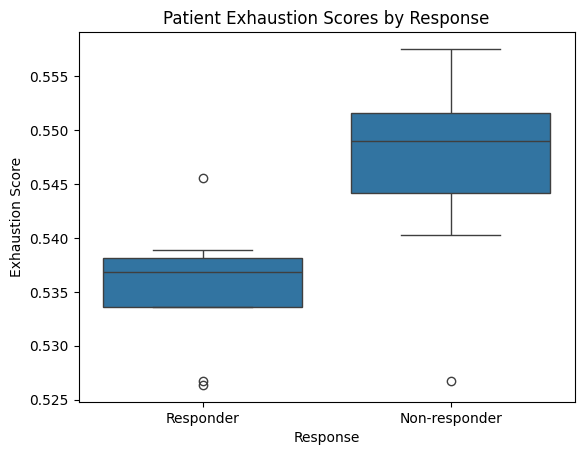

In [16]:
# Boxplot of exhaustion scores by response
sns.boxplot(data=patient_scores, x="response", y="exhaustion_score")
plt.title("Patient Exhaustion Scores by Response")
plt.ylabel("Exhaustion Score")
plt.xlabel("Response")
plt.show()

### Proportion of Exhausted Cells

In [17]:
# Proportion of Exhausted Cells
threshold = 0.6  # Define exhaustion threshold
proportion_exhausted = [
    (E_values_reshaped[:, patient_indices == i] > threshold).mean()
    for i in range(len(np.unique(patient_ids)))
]
patient_scores["proportion_exhausted"] = proportion_exhausted

# Distribution-Based Summarization
patient_median_E = [
    np.median(E_values_reshaped[:, patient_indices == i])
    for i in range(len(np.unique(patient_ids)))
]
patient_q25_E = [
    np.percentile(E_values_reshaped[:, patient_indices == i], 25)
    for i in range(len(np.unique(patient_ids)))
]
patient_q75_E = [
    np.percentile(E_values_reshaped[:, patient_indices == i], 75)
    for i in range(len(np.unique(patient_ids)))
]

# Add distribution-based summarization to DataFrame
patient_scores["median_exhaustion"] = patient_median_E
patient_scores["q25_exhaustion"] = patient_q25_E
patient_scores["q75_exhaustion"] = patient_q75_E

# Display patient_scores DataFrame
print(patient_scores)


   patient_id  exhaustion_score       response  proportion_exhausted  \
0          P1          0.536819      Responder              0.387625   
1         P12          0.540250  Non-responder              0.394110   
2         P15          0.550583  Non-responder              0.411945   
3          P2          0.551859  Non-responder              0.417518   
4         P20          0.545546  Non-responder              0.402655   
5         P24          0.538857      Responder              0.388205   
6         P25          0.543662  Non-responder              0.399574   
7         P26          0.526365      Responder              0.371976   
8         P27          0.550895  Non-responder              0.416011   
9         P28          0.535808      Responder              0.384436   
10        P29          0.545569      Responder              0.403885   
11         P3          0.526766  Non-responder              0.365213   
12        P31          0.547498  Non-responder              0.40

T-statistic: -3.296, P-value: 0.005


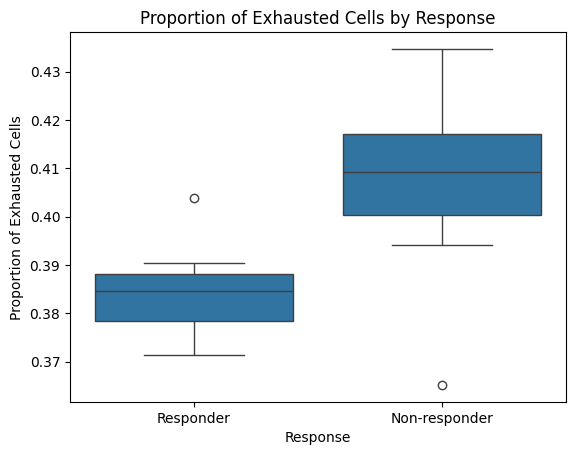

In [18]:
# Separate responders and non-responders
responders = patient_scores[patient_scores["response"] == "Responder"]["proportion_exhausted"]
non_responders = patient_scores[patient_scores["response"] == "Non-responder"]["proportion_exhausted"]

# Perform a t-test to compare proportions between responders and non-responders
t_stat, p_value = stats.ttest_ind(responders, non_responders, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

# Visualize the results
sns.boxplot(x="response", y="proportion_exhausted", data=patient_scores)
plt.title("Proportion of Exhausted Cells by Response")
plt.xlabel("Response")
plt.ylabel("Proportion of Exhausted Cells")
plt.show()

## Proportion of Progenitor Cells

   patient_id  exhaustion_score       response  proportion_exhausted  \
0          P1          0.536819      Responder              0.387625   
1         P12          0.540250  Non-responder              0.394110   
2         P15          0.550583  Non-responder              0.411945   
3          P2          0.551859  Non-responder              0.417518   
4         P20          0.545546  Non-responder              0.402655   
5         P24          0.538857      Responder              0.388205   
6         P25          0.543662  Non-responder              0.399574   
7         P26          0.526365      Responder              0.371976   
8         P27          0.550895  Non-responder              0.416011   
9         P28          0.535808      Responder              0.384436   
10        P29          0.545569      Responder              0.403885   
11         P3          0.526766  Non-responder              0.365213   
12        P31          0.547498  Non-responder              0.40

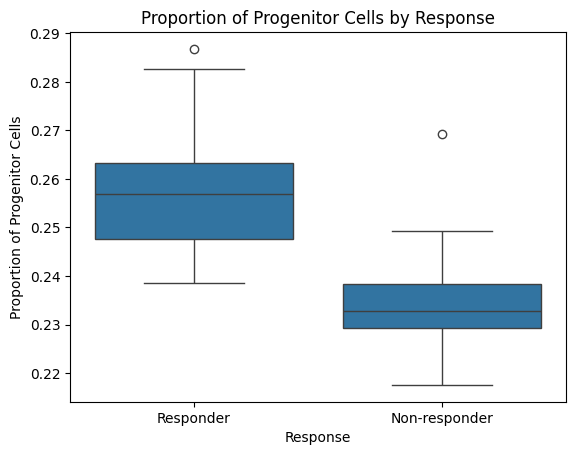

In [19]:
# Define progenitor threshold (cells with exhaustion scores < 0.3)
progenitor_threshold = 0.4

# Calculate the proportion of progenitor cells for each patient
proportion_progenitor = [
    (E_values_reshaped[:, patient_indices == i] < progenitor_threshold).mean()
    for i in range(len(np.unique(patient_ids)))
]
patient_scores["proportion_progenitor"] = proportion_progenitor

# Display the updated DataFrame
print(patient_scores)

# Separate responders and non-responders
responders = patient_scores[patient_scores["response"] == "Responder"]["proportion_progenitor"]
non_responders = patient_scores[patient_scores["response"] == "Non-responder"]["proportion_progenitor"]

# Perform a t-test to compare proportions between responders and non-responders
t_stat, p_value = stats.ttest_ind(responders, non_responders, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.3f}")

# Visualize the proportion of progenitor cells by response
sns.boxplot(x="response", y="proportion_progenitor", data=patient_scores)
plt.title("Proportion of Progenitor Cells by Response")
plt.xlabel("Response")
plt.ylabel("Proportion of Progenitor Cells")
plt.show()

## Further Validation

In [21]:
# Ensure E values match the number of cells in the data
n_cells = gene_expr.shape[0]
E_values_flat = E_values.flatten()[:n_cells]  # Flatten and ensure alignment with cells

# Calculate progenitor and terminal signatures
progenitor_indices = [common_genes.index(gene) for gene in progenitor_ex_genes if gene in common_genes]
terminal_indices = [common_genes.index(gene) for gene in terminal_ex_genes if gene in common_genes]

# Aggregate gene expression for each signature
progenitor_signature = np.mean(gene_expr[:, progenitor_indices], axis=1)
terminal_signature = np.mean(gene_expr[:, terminal_indices], axis=1)

# Create a DataFrame for plotting
signature_df = pd.DataFrame({
    "E": E_values_flat,  # Exhaustion scores
    "Progenitor Signature": progenitor_signature,
    "Terminal Signature": terminal_signature
})

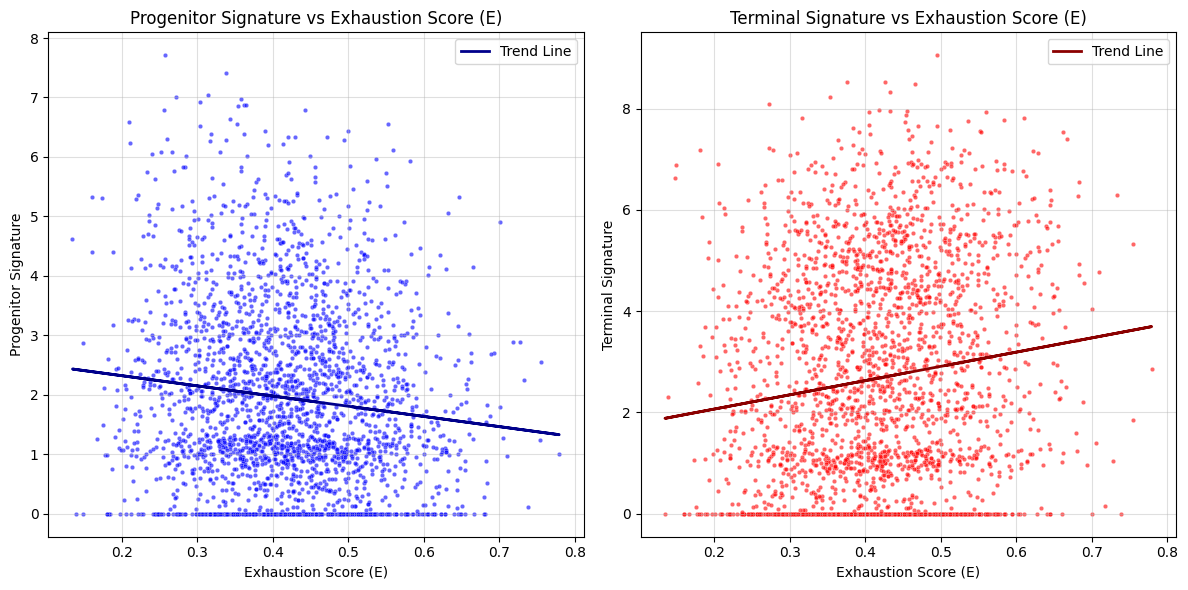

In [22]:
# Progenitor Signature vs. E
X_progenitor = signature_df["E"]
y_progenitor = signature_df["Progenitor Signature"]
X_progenitor_sm = sm.add_constant(X_progenitor)  # Add intercept for regression
model_progenitor = sm.OLS(y_progenitor, X_progenitor_sm).fit()
progenitor_trend = model_progenitor.predict(X_progenitor_sm)

# Terminal Signature vs. E
X_terminal = signature_df["E"]
y_terminal = signature_df["Terminal Signature"]
X_terminal_sm = sm.add_constant(X_terminal)  # Add intercept for regression
model_terminal = sm.OLS(y_terminal, X_terminal_sm).fit()
terminal_trend = model_terminal.predict(X_terminal_sm)

# Plot scatterplots with trend lines
plt.figure(figsize=(12, 6))

# Progenitor Signature
plt.subplot(1, 2, 1)
sns.scatterplot(x="E", y="Progenitor Signature", data=signature_df, alpha=0.6, s=10, color="blue")
plt.plot(X_progenitor, progenitor_trend, color="darkblue", linewidth=2, label="Trend Line")
plt.title("Progenitor Signature vs Exhaustion Score (E)")
plt.xlabel("Exhaustion Score (E)")
plt.ylabel("Progenitor Signature")
plt.legend()
plt.grid(alpha=0.4)

# Terminal Signature
plt.subplot(1, 2, 2)
sns.scatterplot(x="E", y="Terminal Signature", data=signature_df, alpha=0.6, s=10, color="red")
plt.plot(X_terminal, terminal_trend, color="darkred", linewidth=2, label="Trend Line")
plt.title("Terminal Signature vs Exhaustion Score (E)")
plt.xlabel("Exhaustion Score (E)")
plt.ylabel("Terminal Signature")
plt.legend()
plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()


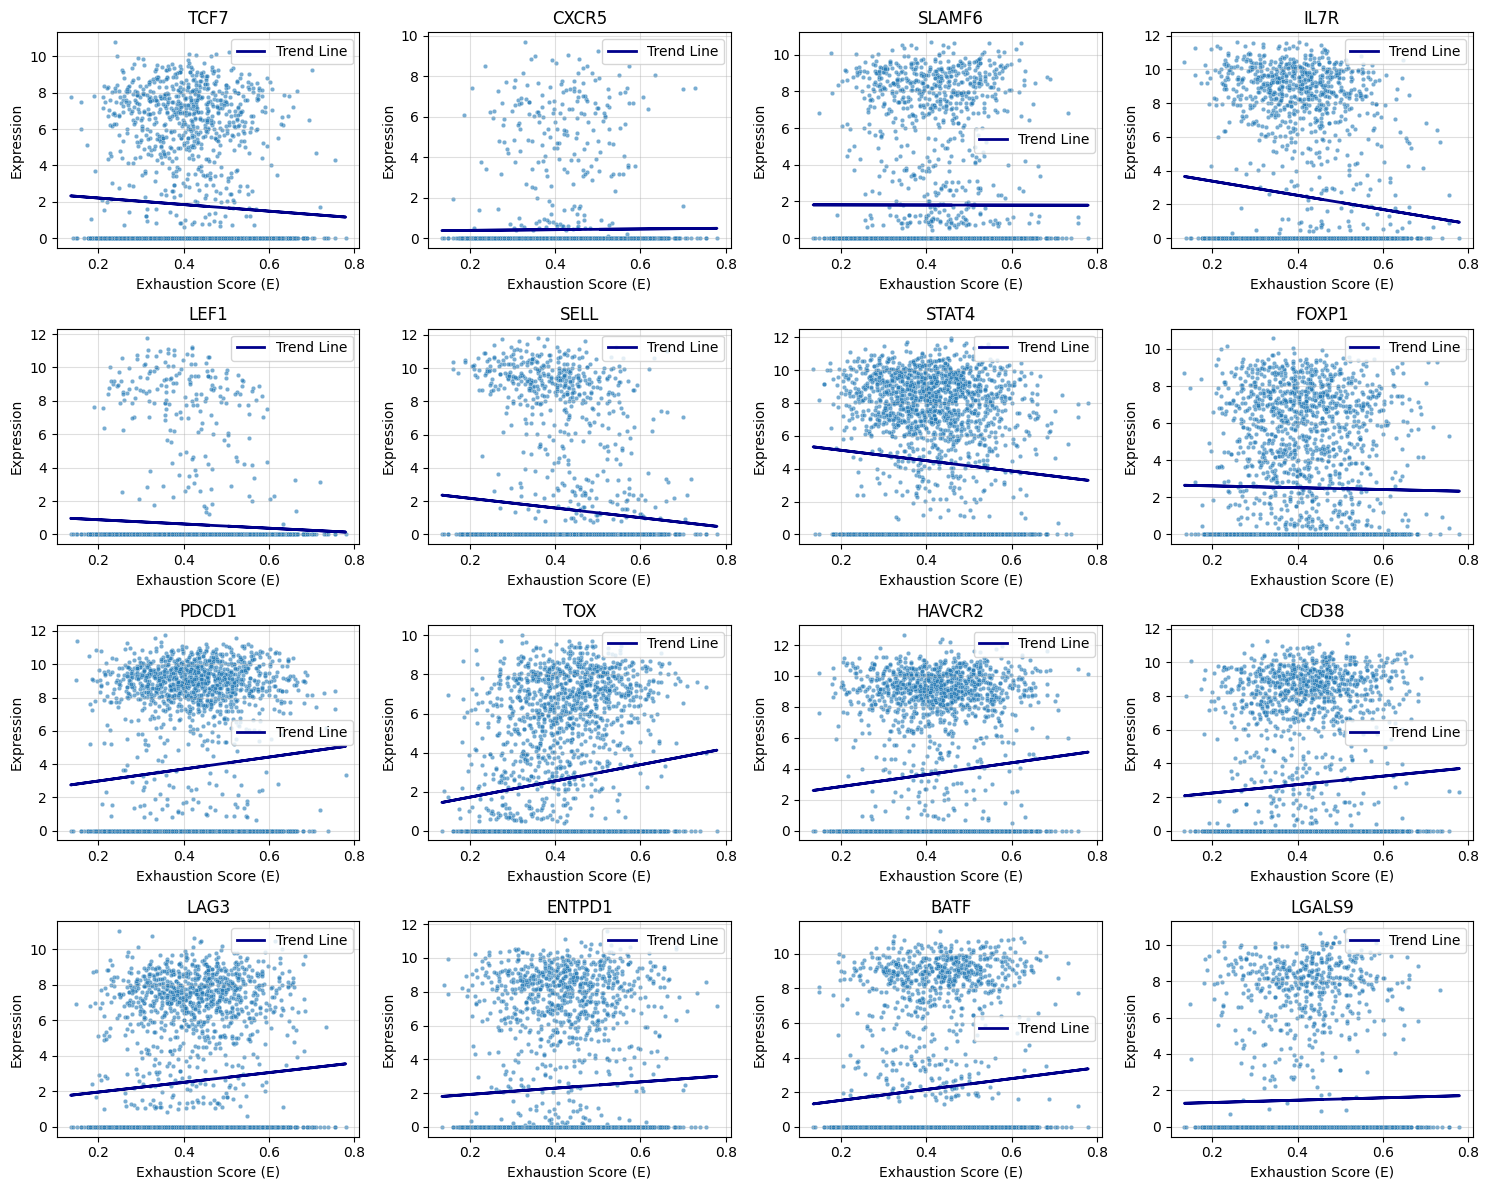

In [23]:
# Create a DataFrame for plotting
gene_expr_df = pd.DataFrame(
    data=gene_expr,
    index=cell_ids,
    columns=common_genes
)
gene_expr_df['E'] = E_values_flat  # Add E values to the DataFrame

# Plot gene expression vs. E for each selected gene with trend lines
plt.figure(figsize=(15, 12))
for i, gene in enumerate(common_genes, 1):
    plt.subplot(4, 4, i)
    
    # Scatterplot
    sns.scatterplot(x='E', y=gene, data=gene_expr_df, alpha=0.6, s=10)
    
    # Add trend line
    X = gene_expr_df['E']
    y = gene_expr_df[gene]
    X_sm = sm.add_constant(X)  # Add intercept for regression
    model = sm.OLS(y, X_sm).fit()
    trend = model.predict(X_sm)
    plt.plot(X, trend, color="darkblue", linewidth=2, label="Trend Line")
    
    # Customize plot
    plt.title(gene)
    plt.xlabel("Exhaustion Score (E)")
    plt.ylabel("Expression")
    plt.legend()
    plt.grid(alpha=0.4)

plt.tight_layout()
plt.show()

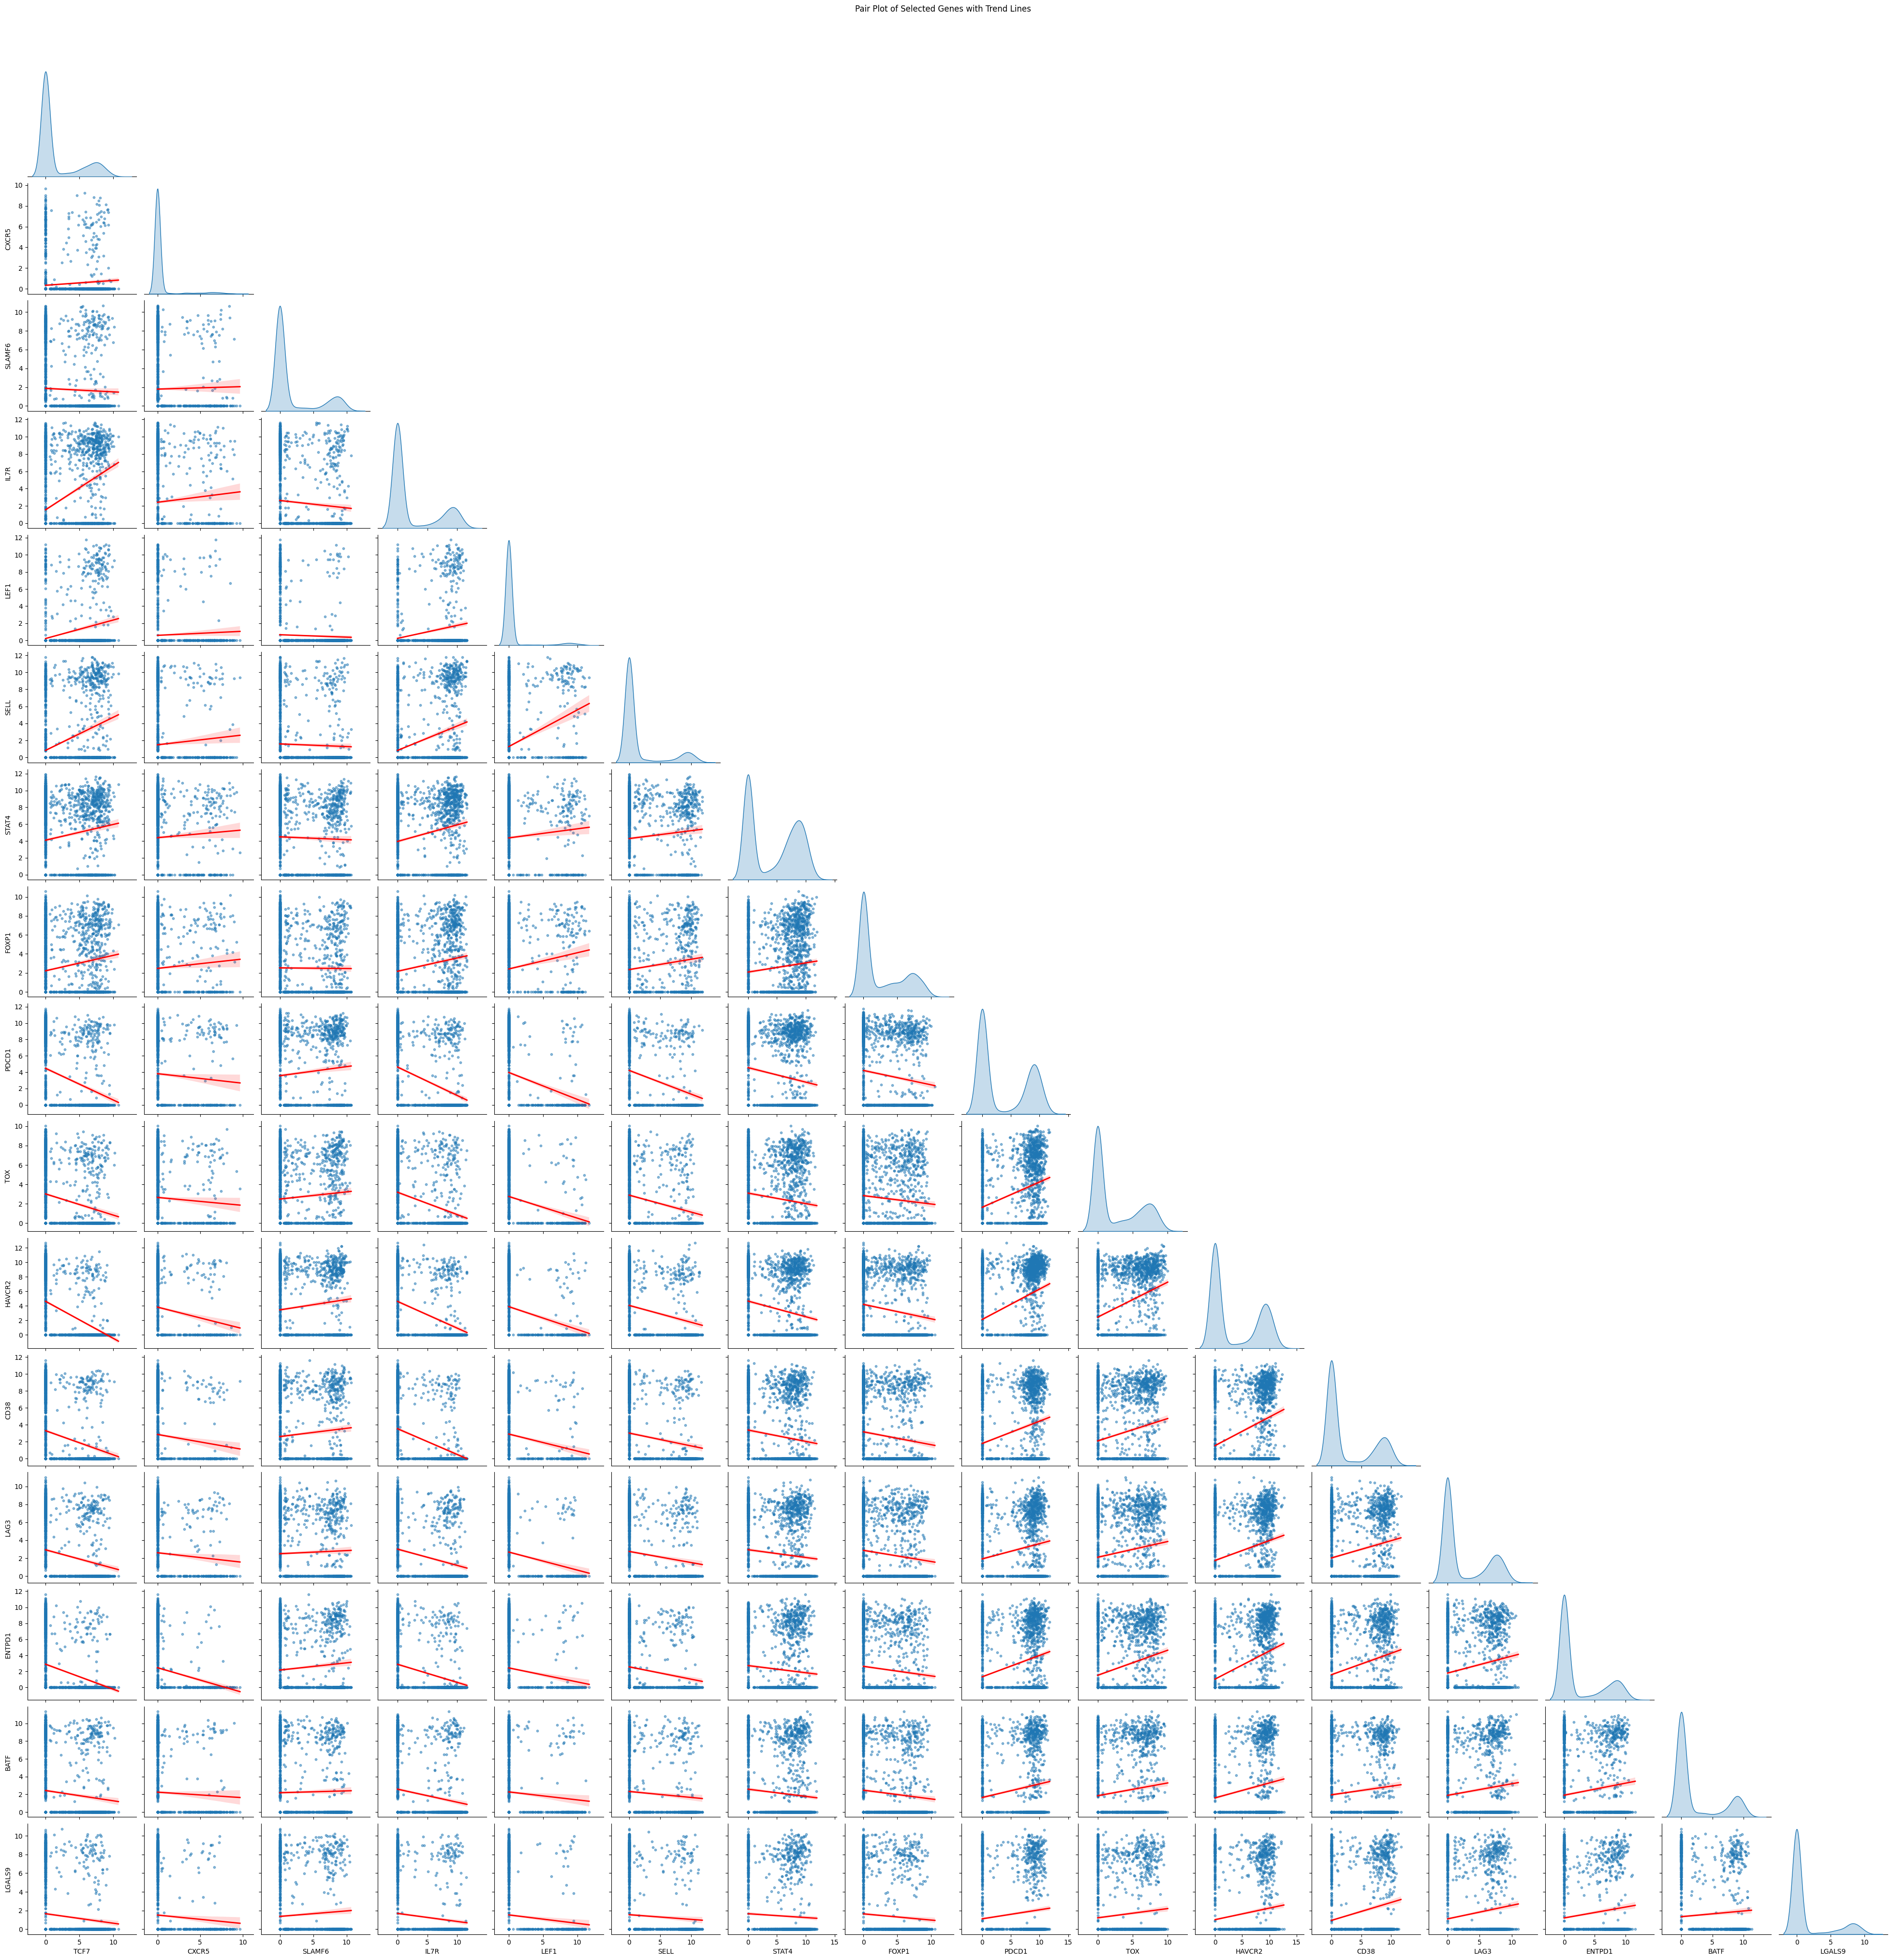

In [24]:
# Create a DataFrame with raw gene expression values
pairplot_df = pd.DataFrame(
    data=gene_expr,
    index=cell_ids,
    columns=common_genes
)

# Subset for the selected genes (progenitor + terminal)
selected_genes_df = pairplot_df[progenitor_ex_genes + terminal_ex_genes]

# Pair plot of the selected genes with trend lines
sns.pairplot(
    selected_genes_df, 
    kind="reg",  # Add regression trend lines
    diag_kind="kde", 
    corner=True, 
    plot_kws={"scatter_kws": {"alpha": 0.5, "s": 10}, "line_kws": {"color": "red", "linewidth": 2}}
)

plt.suptitle("Pair Plot of Selected Genes with Trend Lines", y=1.02)
plt.show()